# Importe

In [35]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import statsmodels.api as sm
import scipy as sp

import matplotlib.pyplot as plt

from uncertainties import ufloat

# plt.rc('text', usetex=True)    # Dieser Befehl überschreibt die Grafiken in LaTeX Formation


# Funktionen

In [36]:
def chi_sq(y, fx, u_y, p=2):    # für 2 Fitparameter
    """
    Variables
      n [int]:                length of the
      y [numpy array]:        y values for the y axis
      fx [numpy array]:       y values from the regression
      u_y[int, numpy array]:  Unsicherheit/uncertainty from y
      p [int]:                number of parameters of the regression
    Return:
      chi square
    """
    n = len(y)
    factor = 1 / (n - p)
    return factor * np.sum((y - fx)**2 / u_y**2)

# Daten

## Versuchsdaten

### Eichfehler Digital-Stoppuhr

In [37]:
def delta_t(T):
    c = 0.01 + 5e-4 * T
    return c


### Teilungsfehler, Messschieber

In [38]:
def delta_l(s):
    c = 5e-5 + 5e-5 * s
    return c


## Geometrie und Masse der Scheibe

In [39]:
# Scheibe
m_s = 245.3 / 1000   # Masse in kg

m_s_err = ufloat(m_s, 0.1 / 1000)
print(m_s_err)
d_s = 4.81 / 100            # Durchmesser m
d_s_err = ufloat(d_s, 5e-5)
r_s = d_s / 2              # Radius in m
r_s_err = d_s_err / 2
r_s_err

0.24530+/-0.00010


0.02405+/-2.5e-05

# daten von Scheibe laden

In [40]:
Sch = pd.read_csv('Daten_Scheibe.txt', sep='\t', index_col='Index')
s = np.array(Sch['s']) / 100                          # in cm
T1_S1 = np.array(Sch['T1']) / 10                         # in Sekunden
T2_S1 = np.array(Sch['T2']) / 10

print(Sch)

s = s[1:]
T1_S = T1_S1[1:]
T2_S = T2_S1[1:]

          s    T1    T2  T_err
Index                         
Tisch   NaN  4.66  4.55    0.5
P1     0.00  4.96  4.98    0.5
P2     1.12  5.02  5.08    0.5
P4     2.81  5.53  5.70    0.5
P5     4.17  6.48  6.50    0.5
P6     5.66  7.51  7.32    0.5
P7     7.14  8.47  8.44    0.5


# Zeit mitteln

In [41]:
# T1 und T2 in einem Array
T_S = np.zeros((7, 2))
for i in range(7):
    for j in range(2):
        if j == 0:
            T_S[i][0] = T1_S1[i]
        else:
            T_S[i][1] = T2_S1[i]

# Mittel von T1 und T2
T_S_mean = np.zeros(7)
for i in range(7):
    T_S_mean[i] = T_S[i].mean()
print(T_S_mean)

# Standardabweichung von T_S
T_S_std = np.zeros(7)
for i in range(7):
    T_S_std[i] = np.std(T_S[i], ddof=1)
T_S_std

[0.4605 0.497  0.505  0.5615 0.649  0.7415 0.8455]


array([0.00777817, 0.00141421, 0.00424264, 0.01202082, 0.00141421,
       0.01343503, 0.00212132])

# Mittlerer Abstand zwischen zwei aneinder liegenden Punkten

In [42]:
s_lst = []
for i in range(len(s)):
    if i == 0:
        k = s[0] - s[i]
        s_lst.append(k)
    else:
        k = s[i] - s[i - 1]
        s_lst.append(k)
s_lst = np.array(s_lst)
print(len(s_lst))
s_lst_std = (s_lst.sum() / (len(s_lst)-1))**0.5
print(s_lst.mean())
print(s_lst_std)

6
0.011899999999999999
0.11949895397031723


# Eichfehler 

In [43]:
# Eichfehler Dig.-Stoppuhr
T1_err = delta_t(T1_S)
T2_err = delta_t(T2_S)

print(T1_err)
print(T2_err)


[0.010248  0.010251  0.0102765 0.010324  0.0103755 0.0104235]
[0.010249 0.010254 0.010285 0.010325 0.010366 0.010422]


In [44]:
# Teilungsfehler
s_err_einzen = delta_l(s)
# print(s)
print(len(s))
u_s = np.array([5e-5, 5e-5, 5e-5, 5e-5, 5e-5, 5e-5])
s_err_einzen

6


array([5.0000e-05, 5.0560e-05, 5.1405e-05, 5.2085e-05, 5.2830e-05,
       5.3570e-05])

Beim Messen wurde ein grober Messfehler gemacht, indem der Experimentator auf die erste Nachkommastelle gerundet hat.
Beispielsweise wurde gemessen: 3.15mm, dann hat der Experimentator wie folgt gerundet: 3.2mm

In [45]:
# ufloat(1120e-5,5.0560e-5)
# 0.00005==5e-5

In [46]:
s_err = np.array([ufloat(0, 5e-5), ufloat(1120e-5, 5e-5), ufloat(2810e-5, 5e-5), ufloat(4170e-5, 5e-5),
ufloat(5660e-5, 5e-5), ufloat(7140e-5, 5e-5)])
s_err

array([0.0+/-5e-05, 0.0112+/-5e-05, 0.0281+/-5e-05, 0.0417+/-5e-05,
       0.0566+/-5e-05, 0.0714+/-5e-05], dtype=object)

# Gleichungen
$$ J_{sch}=0.5 m r^{2}\\ J_{z}=J_{s}+ms^{2}$$
$J_{sch}$ ist das Trägheitsmoment der Scheibe und $J_{z}$ ist der Steinersche Satz

In [47]:
def J_sch(m, r):
    c = 0.5 * m * r**2
    return c


def J_z(m, r, s):
    c = J_sch(m, r) + m * s**2
    return c


# Berechnung von J_Z
J_z_err = J_z(m_s_err, r_s_err, s_err)
print(J_z_err)
J_zz = J_z(m_s, r_s, s)
J_zz = np.array(J_zz)

# error x-Achse
xerr = np.array([1.5e-7, 3e-7, 7e-7, 1.1e-6, 1.4e-6, 1.8e-6])
# J_z_list=np.array(J_z_list)


[7.0941066625e-05+/-1.5029530326629059e-07
 0.000101711498625+/-3.1456549065640727e-07
 0.000264632399625+/-7.131027145749455e-07
 0.000497490783625+/-1.0531905342995427e-06
 0.000856774334625+/-1.4392342138974137e-06
 0.0013214706546250002+/-1.8383461173709667e-06]


In [48]:
# error y-Achse
ut = 2 * T1_S * np.sqrt(0.5**2 + 0.01**2)   # Eichfehler und Reaktionszeit
ut1 = 2 * T1_S * T_S_std[1:]

In [49]:
print(np.min(J_zz), '\n', np.max(J_zz))

7.0941066625e-05 
 0.0013214706546249998


# Lineare Regression

## Regressionsgerade

In [50]:
# Regressionsgerade
def reg_scheibe(x: np.array, a: float, b: float) -> np.array:
    c = 4 * np.pi**2 / a * (x + b)
    return c


ut11 = []
for i in range(6):
    c = ut1[i]
    ut11.append(c)
print(ut1)
print(ut11)

[0.0014029  0.00425961 0.01329502 0.00183282 0.02017941 0.00359352]
[np.float64(0.0014028998538741504), np.float64(0.004259611249867766), np.float64(0.01329502169986948), np.float64(0.001832820776835533), np.float64(0.02017941332150171), np.float64(0.003593516661990171)]


## Bestimmung der Regressionsparameter mit Scipy

### Scheibe, gewichtet

In [51]:
reg_scheibe(np.array([1, 2, 3.14]), 0.1, 0.1)

array([ 434.26259365,  829.04676969, 1279.10073038])

In [52]:
T1_S_sq = T_S_mean[1:]**2
pop, cov = curve_fit(reg_scheibe, J_zz, T1_S_sq, sigma=ut11)
a, b = pop
da, db = np.sqrt(np.diag(cov))
# a=round(a,0)
b = round(b, 5)
# da=round(da,0)
db = round(db, 5)
print(a)
print(b)
print(da)
print(db)
a_err = ufloat(a, da)
b_err = ufloat(b, db)
print('a: ', a_err, ', Standardabweichung', round(da / a * 100, 2), '%')
print('b: ', b_err, ', Standardabweichung', round(db / b * 100, 2), '%')

0.10357068012287009
0.00058
0.002467712268790443
2e-05
a:  0.1036+/-0.0025 , Standardabweichung 2.38 %
b:  0.000580+/-0.000020 , Standardabweichung 3.45 %


In [53]:
# 2*0.466*(0.05+0.001)

In [54]:
a


np.float64(0.10357068012287009)

In [55]:
# Trägheitsmoment des tisches
# teil 1
tt = ufloat(0.4605, 0.05)
J_Tisch = tt**2 / (4 * np.pi**2 / a)
print('J_Tisch 1:', J_Tisch)
print(round(1.2 / 5.6, 2) * 100, '%, mit Reaktionszeit')


# teil 2
t_sq_err = reg_scheibe(0, a_err, b_err)
tisch = t_sq_err / (4 * np.pi**2 / a_err)
print('J_Tisch 2: ', tisch)
print(round(0.2 / 5.6, 2) * 100, '%, mit Standardabweichung')

J_Tisch 1: 0.00056+/-0.00012
21.0 %, mit Reaktionszeit
J_Tisch 2:  0.000580+/-0.000020
4.0 %, mit Standardabweichung


Der große Fehler für das Trägheitsmoment vom Tisch rührt von dem großen Fehler in der Periodendauer, die ihren Ursprung in der Reaktionszeit hat.

## Bestimmung der Regressionsparameter mit Statsmodels

## Scheibe

In [57]:
x = J_zz


# Lineare Regression

y = T_S_mean[1:]**2
x_zunahme = sm.add_constant(x)
results = sm.OLS(y, x_zunahme).fit()
print('''
Lineare Regression
''')
print(results.summary())



Lineare Regression

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2670.
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           8.39e-07
Time:                        14:48:35   Log-Likelihood:                 21.660
No. Observations:                   6   AIC:                            -39.32
Df Residuals:                       4   BIC:                            -39.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2208      0.00

c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


# Unsicherheiten

$$ u_{z}=\sqrt{(\frac{\partial z}{\partial a})^{2}u_{a}^{2}+(\frac{\partial z}{\partial b})^{2}u_{b}^{2}+(\frac{\partial z}{\partial c})^{2}u_{c}^{2}+....}$$

In [58]:
m = 1.352
u_m = 0.0001
r = 0.02405
u_r = (2.5e-5)

## Unsicherheit $T^{2}$

$$ T_{sq}=\left(\frac{T}{10}\right)^{2}\\ \Rightarrow u_{T^2}=\sqrt{\frac{4 T^{2}}{100^{2}}u_{T}^{2}}\\=\frac{2}{100}T u_{T}$$
$u_{T}$ ist Eichfehler von Stoppuhr 

In [59]:
u_t_sq = 2 * T_S_mean[1:] * delta_t(T_S_mean[1:])
print('Unsicherheit von $T^{2}$: ', u_t_sq)

Unsicherheit von $T^{2}$:  [0.01018701 0.01035503 0.01154528 0.0134012  0.01537982 0.01762487]


## Unsicherheit $J_{sch}$

$$ J_{sch}=\frac{1}{2} m r^{2}\\ u_{J_{sch}}=\frac{1}{2}\sqrt{u_{m}^{2}r^{4}+(2 m r u_{r})^{2}}\\=\frac{r^{2}}{2}\sqrt{u_{m}^{2} r^{2}+(2 m   u_{r})^{2}}$$

In [60]:
u_sch = r**2 / 2 * np.sqrt(u_m**2 * r**2 + 4 * m**2 * u_r**2)
u_sch

np.float64(1.9562372978464435e-08)

## Unsicherheit $J_{Z}$

$$ J_{z}=\frac{1}{2} m r^{2}+ms^{2}\\ u_{Z}=\sqrt{\frac{r^{2}}{4}(u_{m}^{2} r^{2}+(2 m   u_{r})^{2})+u_{m}^{2}s^{4}+4(ms)^{2}u_{s}^{2}} $$

In [61]:
u_z = np.sqrt(r**2 / 2 * (u_m**2 * r**2 + 4 * m**2 * u_r**2) + u_m**2 * s**2 + s**2 * 4 * m**2 * u_s**2)
u_z

array([1.15032737e-06, 2.20693811e-06, 4.86340064e-06, 7.10615177e-06,
       9.58732780e-06, 1.20618683e-05])

## Unsicherheit $J_{tisch}$

$$ T^{2}=\frac{4\pi^{2}}{D}(J_{Z}=0)+\frac{4\pi^{2}}{D}J_{Tisch}\\ T^{2}=\frac{4\pi^{2}}{D}J_{Tisch}\\J_{Tisch}=\frac{D}{4\pi^{2}}T^{2} \\ \Rightarrow u_{J_{tisch}}=\frac{1}{4\pi^{2}}\sqrt{u_{D}^{2}T^{4}+2DT^{2}u_{T}^{2}}$$

In [62]:
T_sq = T_S_mean[0]**2
u_T_sq = 2 * T_S_mean[0] * 0.01
D = a
u_D = da

In [63]:
u_tisch = 1 / (4 * np.pi**2) * np.sqrt(u_D**2 * T_sq**2 + 2 * D * T_sq * u_T_sq)
u_tisch

np.float64(0.0005096594264693058)

In [64]:
# J_tisch
jj_tisch = D / (4 * np.pi) * T_S_mean[0]**2
print('J_tisch', jj_tisch)
print('Fehler: ', u_tisch, ' in %: ', u_tisch / jj_tisch * 100)

J_tisch 0.0017477778583443353
Fehler:  0.0005096594264693058  in %:  29.160423565046457


# Plot

[0.0028058  0.00851922 0.02659004 0.00366564 0.04035883 0.00718703]
[3.0e-07 6.0e-07 1.4e-06 2.2e-06 2.8e-06 3.6e-06]


<>:18: SyntaxWarning: invalid escape sequence '\c'
<>:18: SyntaxWarning: invalid escape sequence '\c'
C:\Users\benjf\AppData\Local\Temp\ipykernel_27084\3123755368.py:18: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel('Trägheitsmoment $J_{z}$ [kg$\cdot$m$^{2}$]')


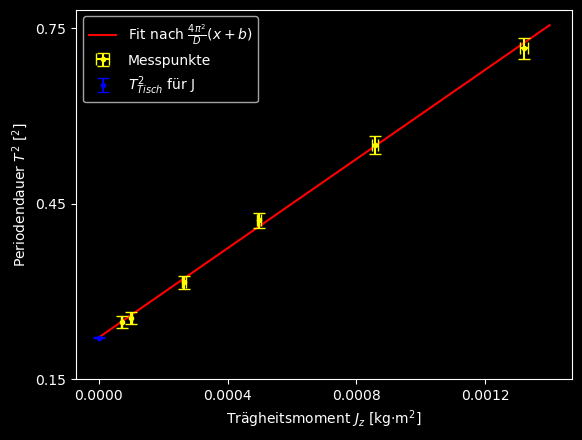

In [65]:

xx = np.linspace(0, 0.0014, 500)
# print(xx)
# print(xerr)
# print(J_zz)
u = 2 * np.array(ut11)
print(u)
x_sig = 2 * np.array(xerr)
print(x_sig)
plt.errorbar(J_zz, T1_S_sq, xerr=u_z, yerr=u_t_sq, fmt='.', color='yellow', label='Messpunkte', capsize=4, zorder=2)
plt.plot(xx,
    reg_scheibe(xx, a, b),
    'r',
    label=r'Fit nach $\frac{4 \pi^{2}}{D}(x+b)$',
    zorder=1)
plt.errorbar(0, reg_scheibe(0, a, b), yerr=(0.00004), fmt='b.', label='$T_{Tisch}^{2}$ für J', capsize=4)
plt.xticks(np.arange(0, 0.0016, step=4e-4))
plt.yticks(np.arange(0.15,0.99,step=0.3))
plt.xlabel('Trägheitsmoment $J_{z}$ [kg$\cdot$m$^{2}$]')
plt.ylabel('Periodendauer $T^{2}$ $[^{2}]$')
plt.legend()

plt.show()
# plt.savefig('Regression_M2_J_Tisch.png',dpi=500)

In [66]:
J_zz

array([7.09410666e-05, 1.01711499e-04, 2.64632400e-04, 4.97490784e-04,
       8.56774335e-04, 1.32147065e-03])

In [67]:
T1_S_sq

array([0.247009  , 0.255025  , 0.31528225, 0.421201  , 0.54982225,
       0.71487025])

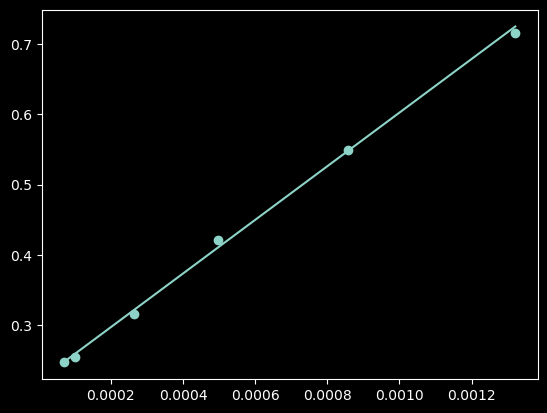

In [68]:
plt.scatter(J_zz, T1_S_sq)
plt.plot(J_zz, reg_scheibe(J_zz, a, b))
plt.show()

Die Fehlerbalken sind in der Fehlerfortpflanzung entstanden,

$R^{2}=0.999$

$\chi^{2}=2.5$

In [73]:
chi_sq(T1_S_sq, reg_scheibe(J_zz, a, b), u_t_sq, p=2)

np.float64(0.37801663287844695)

In [ ]:
J_z

In [75]:
# sp.stats.chisquare(J_zz, T1_S_sq, ddof=2)